In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

bitcoin = yf.download("BTC-USD",start="2010-05-18",end="2025-06-02")['Close']
bitcoin = bitcoin.reset_index()

training = bitcoin.iloc[:,1:2].values
training

cuda:0
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


array([[   457.33401489],
       [   424.44000244],
       [   394.79598999],
       ...,
       [103998.5703125 ],
       [104638.09375   ],
       [105652.1015625 ]], shape=(3911, 1))

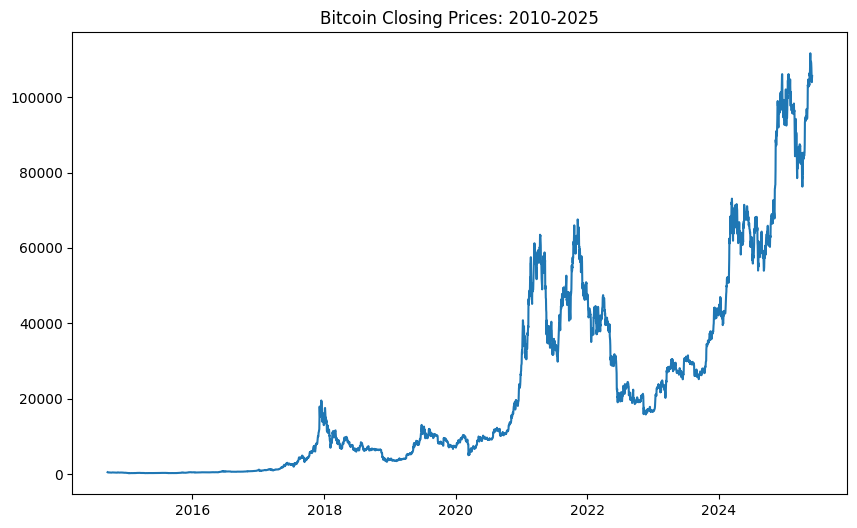

In [2]:
plt.figure(figsize=(10,6))
plt.plot(bitcoin['Date'],bitcoin['BTC-USD'])
plt.title("Bitcoin Closing Prices: 2010-2025")
plt.savefig("images/closing_prices.png")
plt.show()

In [3]:

train_size = int(len(training)* .80)

train_data = training[:train_size]
test_data = training[train_size:]
print(len(train_data))
print(len(test_data))


3128
783


In [4]:

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [5]:


def slider(df,seq_length):
    X,y = [],[]
    for i in range(len(df) - seq_length):
        X_ = df[i:(seq_length + i)]
        y_ = df[(seq_length + i)]
        X.append(X_)
        y.append(y_)
    return np.array(X),np.array(y)

seq_length = 5
X_train,y_train = slider(train_data,seq_length)
X_test,y_test = slider(test_data,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [6]:


class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        c0 = torch.zeros(self.num_layers,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_16280\1364446629.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_16280\1364446629.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2367; Test RSME: 0.8083
Epoch: 1; train_RSEM: 0.2315; Test RSME: 0.6715
Epoch: 2; train_RSEM: 0.2238; Test RSME: 0.6184
Epoch: 3; train_RSEM: 0.2035; Test RSME: 0.6197
Epoch: 4; train_RSEM: 0.1895; Test RSME: 0.6237
Epoch: 5; train_RSEM: 0.1781; Test RSME: 0.5962
Epoch: 6; train_RSEM: 0.1552; Test RSME: 0.5071
Epoch: 7; train_RSEM: 0.1143; Test RSME: 0.3201
Epoch: 8; train_RSEM: 0.09126; Test RSME: 0.05267
Epoch: 9; train_RSEM: 0.07179; Test RSME: 0.2887
Epoch: 10; train_RSEM: 0.05736; Test RSME: 0.307
Epoch: 11; train_RSEM: 0.1097; Test RSME: 0.3279
Epoch: 12; train_RSEM: 0.0904; Test RSME: 0.4325
Epoch: 13; train_RSEM: 0.07332; Test RSME: 0.4827
Epoch: 14; train_RSEM: 0.04943; Test RSME: 0.3369
Epoch: 15; train_RSEM: 0.03004; Test RSME: 0.1317
Epoch: 16; train_RSEM: 0.05173; Test RSME: 0.0918
Epoch: 17; train_RSEM: 0.06629; Test RSME: 0.1457
Epoch: 18; train_RSEM: 0.06902; Test RSME: 0.1488
Epoch: 19; train_RSEM: 0.06681; Test RSME: 0.1114
Epoch: 20; train_RSE

In [9]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = bitcoin.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))


         Date  Actual Price  Predicted Price
0  2023-04-16  30315.355469     30511.199219
1  2023-04-17  29445.044922     30518.837891
2  2023-04-18  30397.552734     30381.769531
3  2023-04-19  28822.681641     30311.355469
4  2023-04-20  28245.990234     30056.074219
5  2023-04-21  27276.912109     29595.990234
6  2023-04-22  27817.500000     28965.589844
7  2023-04-23  27591.384766     28549.705078
8  2023-04-24  27525.341797     28079.708984
9  2023-04-25  28307.597656     27858.414062
10 2023-04-26  28422.701172     27876.533203
11 2023-04-27  29473.787109     28128.470703
12 2023-04-28  29340.261719     28470.035156
13 2023-04-29  29248.488281     28875.371094
14 2023-04-30  29268.806641     29201.066406
15 2023-05-01  28091.568359     29362.935547
16 2023-05-02  28680.539062     29279.101562
17 2023-05-03  29006.308594     29048.316406
18 2023-05-04  28847.710938     28989.363281
19 2023-05-05  29534.384766     28961.216797
          Date   Actual Price  Predicted Price
758 2025

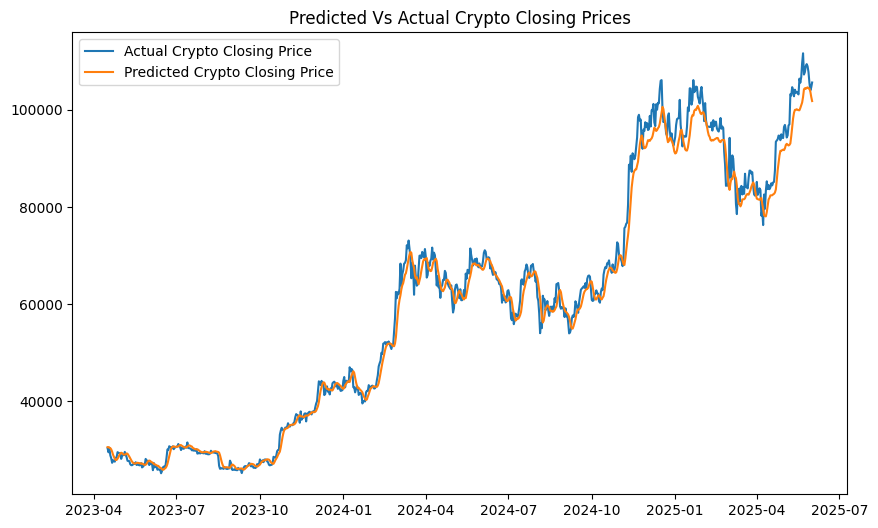

In [8]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df['Actual Price'],label="Actual Crypto Closing Price")
plt.plot(comparison_df['Date'],comparison_df['Predicted Price'],label="Predicted Crypto Closing Price")
plt.title("Predicted Vs Actual Crypto Closing Prices")
plt.savefig("images/predicted_vs_actual_closing_prices")
plt.legend()
plt.show()





